---
title: "Unsupervised Learning"
format:
    html: 
        code-fold: false
---

## Introduction
In this stage, I will be utilizing unsupervised learning techniques such as the different clustering methods below to uncover relationships between variables.

## Overview of Methods
In this section, I will utilize PCA, t-SNE, K-Means Clustering, DBSCAN and Hierarchical Clustering. I will go into detail about each of these methods in the sections below.

# Code 

In [ ]:
# Import necessary packages
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Load your dataframe
df = pd.read_csv('../../data/processed-data/ces_clean_normalized.csv')

# Select relevant numerical columns for analysis
boxcox_continuous_col = ['boxcox_total_income', 'boxcox_total_expense', 'boxcox_online_expense', 'age', 'boxcox_online_percent']
continuous_cols = ['total_expense', 'online_expense', 'online_percentage', 'total_income', 'age']

# Drop rows that have nulls in those columns
X = df[boxcox_continuous_col].dropna()
X1 = df[continuous_cols].dropna()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled1 = scaler.fit_transform(X1)


### Part 1: Dimensionality Reduction ###

**PCA (Principal Component Analysis)**

- PCA is a dimensionality reduction technique that transforms a set of correlated variables into a set of uncorrelated variables called principal components (PCs). We will visualize each component's explained variance to see the corresponding impact. Equally importantly, we examine the loadings for each PC as loadings represent the correlation between a feature and a PC. This will allow us to assign our dataset features to PCs for further analysis.
- **How it works:**
  1. **Standardization:** Standardize the data to have zero mean and unit variance.
  2. **Covariance Matrix:** Calculate the covariance matrix of the standardized data.
  3. **Eigenvalue Decomposition:** Decompose the covariance matrix to obtain eigenvalues and eigenvectors.
  4. **Principal Components:** Sort the eigenvectors by their corresponding eigenvalues in descending order. The eigenvectors with the largest eigenvalues correspond to the principal components.
- **Inputs:** A dataset with numerical features.
- **Outputs:** A lower-dimensional representation of the data.
- **Key Hyperparameters:**
  - **Number of Components:** The desired number of dimensions in the reduced space.

Feature Loadings:
boxcox_total_income      : 0.4440, 0.5418
boxcox_total_expense     : 0.4417, 0.5461
boxcox_online_expense    : 0.5903, -0.3793
age                      : -0.0475, 0.1363
boxcox_online_percent    : 0.5071, -0.4957


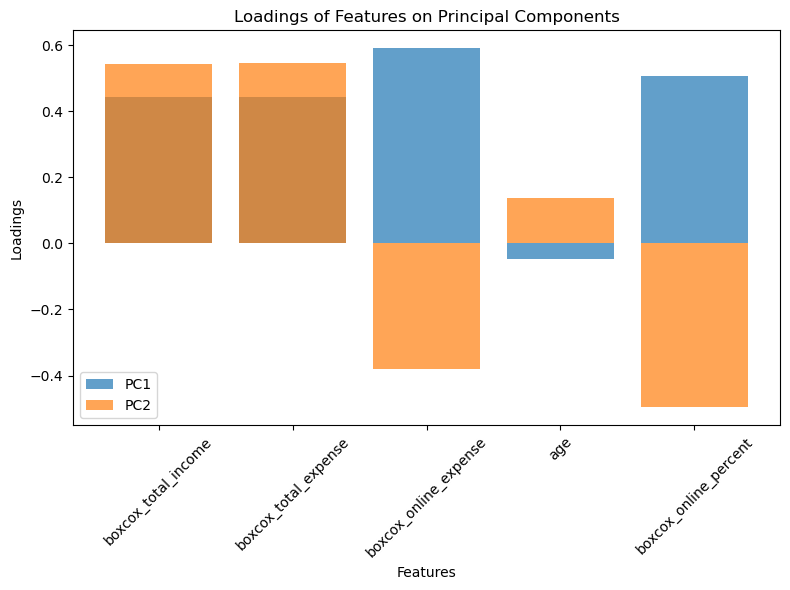

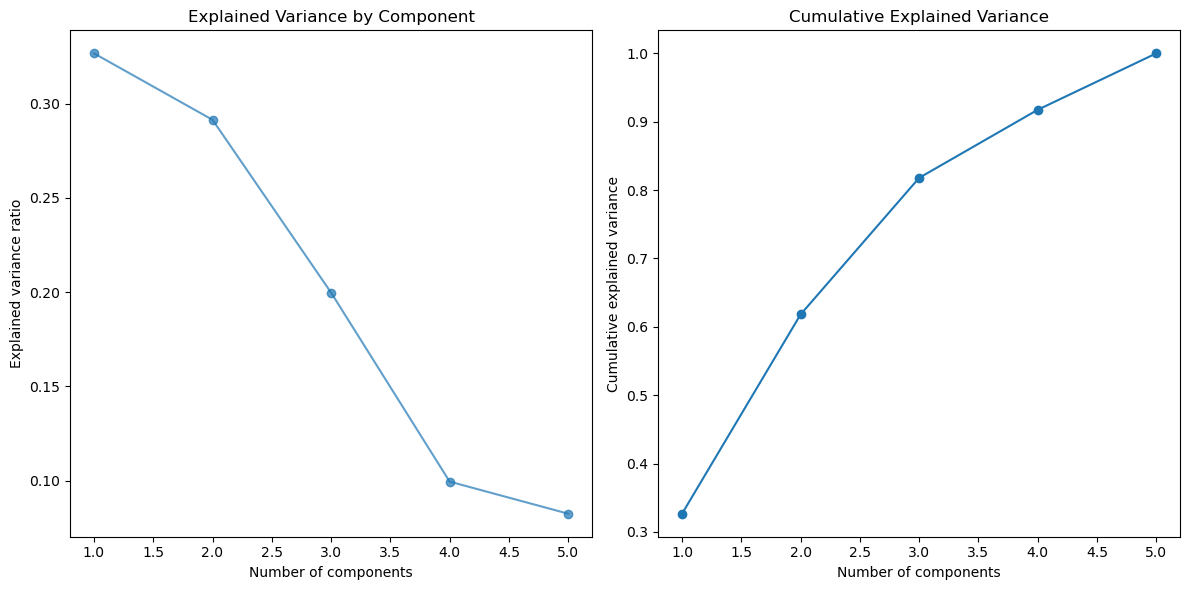

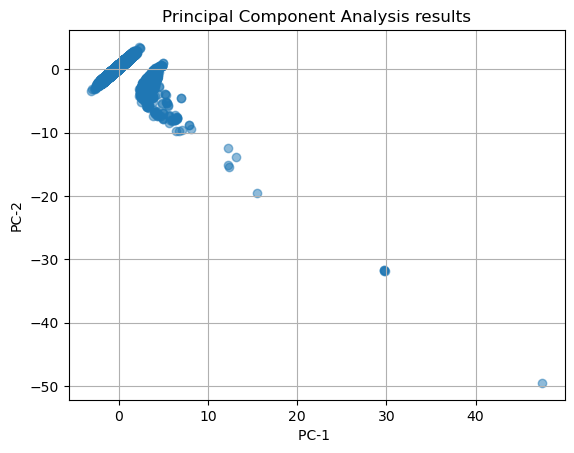

In [3]:
# PCA

# UTILITY PLOTTING FUNCTION
def plot_2D(X,color_vector):
    fig, ax = plt.subplots()
    ax.scatter(X[:,0], X[:,1],c=color_vector, alpha=0.5) #, c=y
    ax.set(xlabel='PC-1 ', ylabel='PC-2',
    title='Principal Component Analysis results')
    ax.grid()
    plt.show()

def plot_variance_explained(pca):
    """
    Plots the explained variance and cumulative explained variance for PCA components.
    
    Parameters:
    - pca: A fitted PCA object from sklearn.decomposition.PCA.
    """
    # Explained variance for each component
    explained_variance = pca.explained_variance_ratio_
    
    # Plot explained variance
    plt.figure(figsize=(12, 6))
    
    # Plot individual explained variance
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', alpha=0.7)
    plt.xlabel('Number of components')
    plt.ylabel('Explained variance ratio')
    plt.title('Explained Variance by Component')
    
    # Plot cumulative explained variance
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o')
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.title('Cumulative Explained Variance')
    
    plt.tight_layout()
    plt.show()


# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

# Analyze feature loadings
loadings = pca.components_  # Loadings matrix

# Print feature names and loadings for the first two principal components
print("Feature Loadings:")
for i, feature in enumerate(boxcox_continuous_col):
    print(f"{feature:<25}: {loadings[0][i]:.4f}, {loadings[1][i]:.4f}")

# Visualize loadings (optional)
plt.figure(figsize=(8, 6))
plt.bar(boxcox_continuous_col, loadings[0], label='PC1', alpha=0.7)
plt.bar(boxcox_continuous_col, loadings[1], label='PC2', alpha=0.7)
plt.xlabel('Features')
plt.ylabel('Loadings')
plt.title('Loadings of Features on Principal Components')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Plot explained variance
plot_variance_explained(pca)

# Visualize the first two principal components using custom function
plot_2D(pca_result, color_vector=None)



### Loadings of Features on Principal Components Results
From the feature loading values and the biplot, we see that PC-1 is positively correlated with boxcox_total_income, boxcox_total_expense, boxcox_online_expense, and boxcox_online_percent. Features with high positive loadings on PC1 are positively correlated with each other. This suggests that a high value in one of these features tends to be associated with high values in the others, and that these features contribute to PC-1. This PC might represent a general measure of overall spending and online activity.

PC-2 is positively correlated boxcox_total_income, boxcox_total_expense, and age as these variables have positive loadings, while PC-2 is negatively correlated with boxcox_online_expense and boxcox_online_percent as they have negative loadings.This PC seems to capture a contrast between online and offline spending. A high score on PC2 might indicate an affinity for online spending, while a low score might indicate a preference for offline spending. Thus, this PC could be interpreted as an "online vs. offline" dimension.

### Optimal Number of Principal Components
- **Explained Variance Plot**: The plot of explained variance ratio shows that the variance explained by each component decreases significantly after the first component and continues to decrease gradually.
- **Cumulative Explained Variance Plot**: From the cumulative explained variance, 5 components explain nearly 100% of the variance in the data. Therefore, I will select 4 as the optimal number of components as according to the plot, it explains about 90% of the variance. We don't want to select 5 to reduce noise, prevent overfitting, and improve model performance. 

### PCA Results Interpretation
- The first principal component captures the largest proportion of the variance, indicating it holds the most significant relationships among variables. From the plot, we can see that data points are more spread out on the PC1 axis compared to the PC2. Also, in the Explained Variance Plot, component 1 explains about 32% of the variance while component 2 explains around 23%. Thus, since additional components explain smaller amounts of variance, they may represent finer details or noise in the dataset.
- There seem to be 3 clusters of points which suggests that some groups of customers have similar characteristics.
- There are a few points that are further away, top right, which could represent outliers. 

### Implications for Analysis
- **Visualization**: Retaining **2 components** for plots (like scatter or clustering visualizations) makes the data more interpretable in a 2D space.
- **Dimensionality Reduction**: Retaining 4 components will allow the dataset to preserve most of its variance while improving computational efficiency for downstream machine learning tasks like clustering or classification.

---

**t-SNE (t-Distributed Stochastic Neighbor Embedding)**

- t-SNE is a nonlinear dimensionality reduction technique that maps high-dimensional data to a lower-dimensional space, often 2D or 3D, while preserving local structure.
- **How it works:**
  1. **Probability Distribution:** Calculate the probability of similarity between data points in the high-dimensional space.
  2. **Low-Dimensional Embedding:** Map the data points to a lower-dimensional space and calculate the probability distribution in this space.
  3. **Minimize Kullback-Leibler Divergence:** Minimize the KL divergence between the high-dimensional and low-dimensional probability distributions using gradient descent.
- **Inputs:** A dataset with numerical features.
- **Outputs:** A lower-dimensional representation of the data.
- **Key Hyperparameters:**
  - **Perplexity:** Controls the balance between local and global structure.
  - **Learning Rate:** Determines the step size in the optimization process.
  - **Iteration:** The number of iterations to run the algorithm.

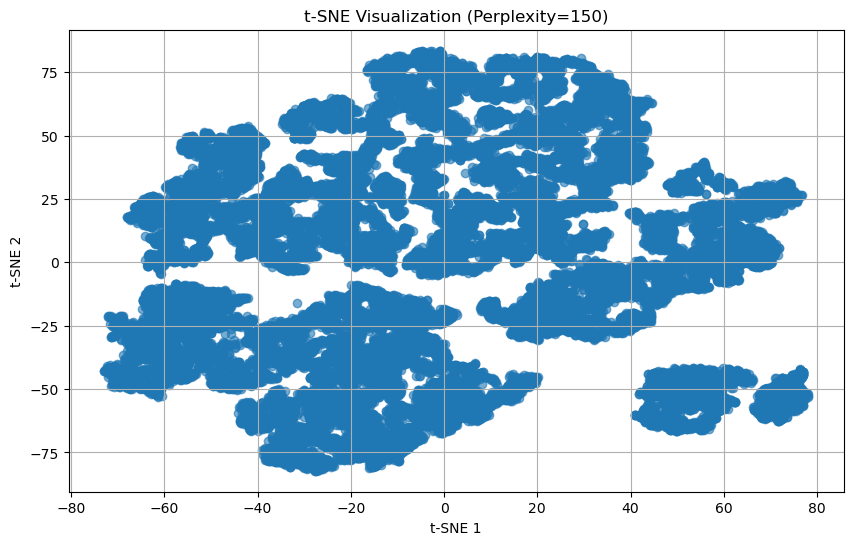

In [10]:
# t-SNE
# Experiment with different levels of perplexity: effective number of nearest neighbors for each data point
tsne = TSNE(n_components=2, perplexity=150, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)

# Visualize t-SNE
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.6)
plt.title('t-SNE Visualization (Perplexity=150)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid()
plt.show()


### Comparison and Evaluation of PCA and t-SNE

**PCA Results:**
  - PCA visualizes the data in terms of variance-preserving principal components. 
  - The first two components capture most of the variance, but the clusters are not distinctly separated. 
  - It seems to reduce dimensionality effectively, but the overlap of data points suggests that PCA struggles with non-linear relationships in the dataset.


**t-SNE Results:**
  - t-SNE preserves local relationships between data points and effectively separates clusters in a non-linear manner.
  - It generates a clearer visualization of potential groupings, showing 3-4 distinct structures that PCA does not capture. However, there is some confusion as to the exact number of clusters there are.


### **Effectiveness in Preserving Data Structure:**
- **PCA:** Preserves the global structure of the data by maximizing variance explained by each component. It is ideal for datasets with linear relationships but struggles with non-linear data.
- **t-SNE:** Excels in preserving local neighborhood structures and identifying clusters but may distort global structures. It effectively separates clusters in a non-linear manner.

### **Visualization Capabilities:**
- **PCA:** Useful for interpretability, showing directions of maximum variance. The visualization is often less clear for identifying clusters unless the dataset has inherent linear separations.
- **t-SNE:** Better for EDA, especially when clustering or non-linear separations exist. The visualization clearly shows separations, making it suitable for identifying subgroups or hidden patterns.

### **Trade-offs and Scenarios:**
- Use **PCA** when:
  - Dimensionality reduction is required for further analysis (e.g., after clustering, regression).
  - Interpretability and computational efficiency are critical.
  - The dataset exhibits primarily linear relationships.

- Use **t-SNE** when:
  - The goal is exploratory visualization and identification of patterns or clusters.
  - Non-linear relationships dominate the dataset.
  - Working on datasets with moderate size (due to its computational cost).

---

### Part 2: Clustering Methods ###
1. **K-Means**

- K-Means is a popular clustering algorithm that partitions data into a specified number (K) of clusters. It operates iteratively, aiming to minimize the within-cluster sum of squares (WCSS). Its purpose is to group similar data points together based on their features. It is useful for tasks like customer segmentation, image segmentation, and anomaly detection.
- **How it works:**
  1. **Initialization:** Randomly select K data points as initial cluster centroids.
  2. **Assignment:** Assign each data point to the nearest cluster centroid.
  3. **Update Centroids:** Recalculate the cluster centroids as the mean of the assigned data points.
  4. **Iteration:** Repeat steps 2 and 3 until convergence.
- **Inputs:** A dataset with numerical features, the number of clusters (K).
- **Outputs:** Cluster assignments for each data point.
- **Key Hyperparameters:**
  - **Number of Clusters (K):** The desired number of clusters.
- **Model Selection:** To select the optimal K, one can simultaneously utilize the Elbow Method and the corresponding Silhoutte Score. 
  - The **Elbow Method** looks for an "elbow" in the plot of the inertia (or within-cluster sum of squares) against the number of clusters (k). This "elbow" point indicates where adding more clusters doesn't significantly reduce the inertia.
  - The **Silhouette Score** measures how similar a data point is to its own cluster compared to other clusters.1 Higher Silhouette Scores indicate better-defined clusters

k=2, Inertia=155013.79, Silhouette Score=0.258
k=3, Inertia=106392.37, Silhouette Score=0.318
k=4, Inertia=88698.09, Silhouette Score=0.313
k=5, Inertia=69233.06, Silhouette Score=0.315
k=6, Inertia=59357.33, Silhouette Score=0.295
k=7, Inertia=53158.97, Silhouette Score=0.295
k=8, Inertia=49385.81, Silhouette Score=0.281
k=9, Inertia=45313.68, Silhouette Score=0.293
k=10, Inertia=41586.64, Silhouette Score=0.286
k=11, Inertia=39153.71, Silhouette Score=0.271
k=12, Inertia=37586.86, Silhouette Score=0.262
k=13, Inertia=34044.70, Silhouette Score=0.254
k=14, Inertia=33555.36, Silhouette Score=0.276
k=15, Inertia=31321.24, Silhouette Score=0.262
k=16, Inertia=30098.92, Silhouette Score=0.261
k=17, Inertia=28452.72, Silhouette Score=0.266
k=18, Inertia=27564.83, Silhouette Score=0.259
k=19, Inertia=26090.98, Silhouette Score=0.260


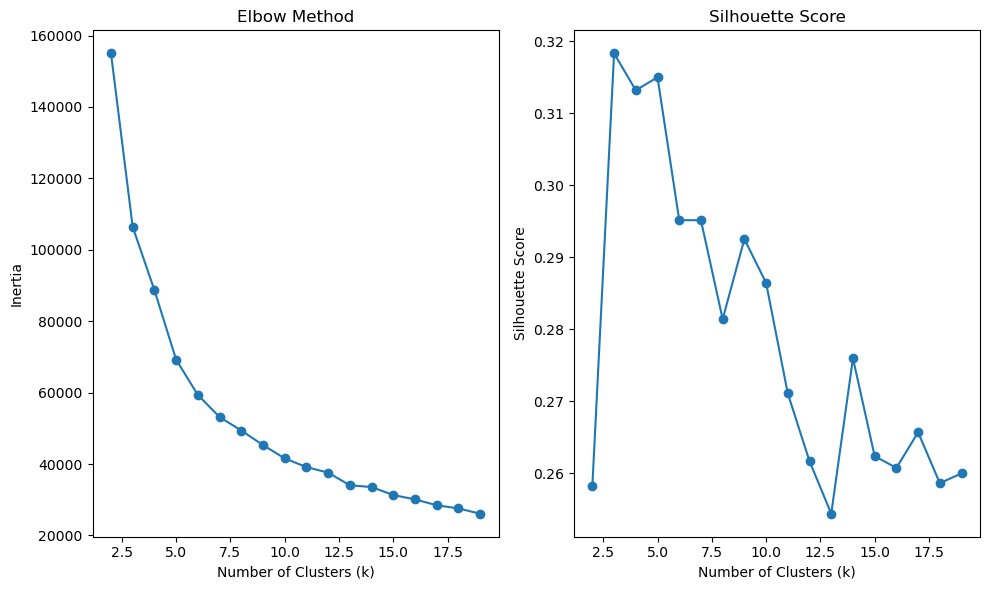

In [6]:
# Hyper-parameter tuning for K clusters
def kmean_fit(data,k):
   
    model = KMeans(n_clusters=k,max_iter=5000,tol=1e-6) #creates KMeans model isntance with k clusters, max of 5k inerations, and tolerance = 1e-6 for stopping the optimization
    model.fit(data) #fits the KMeans model on the df
    return model.inertia_, silhouette_score(data, model.labels_) #retrives inertia value and silhouette score of the model

ks=[]
inertias=[]
silhouette_scores = []

# grid search of number of clusters
for k in range(2,20):
    inertia, silhouette_avg = kmean_fit(X_scaled, k) #get inertia value and silhouette score for each k value in loop 
    ks.append(k)
    inertias.append(inertia)
    silhouette_scores.append(silhouette_avg)
    print(f"k={k}, Inertia={inertia:.2f}, Silhouette Score={silhouette_avg:.3f}")


# Plot Inertia and Silhouette Score into 2 grahs
# Elbow Method
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(ks, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
# Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(ks, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.tight_layout()
plt.show()


We will select **5** as the optimal number of clusters as from the Elbow method, beyond 5 clusters, the rate of decrease of inertia diminishes. Additionally, 5 clusters is a local maximum with a silhouette score of 0.315. 

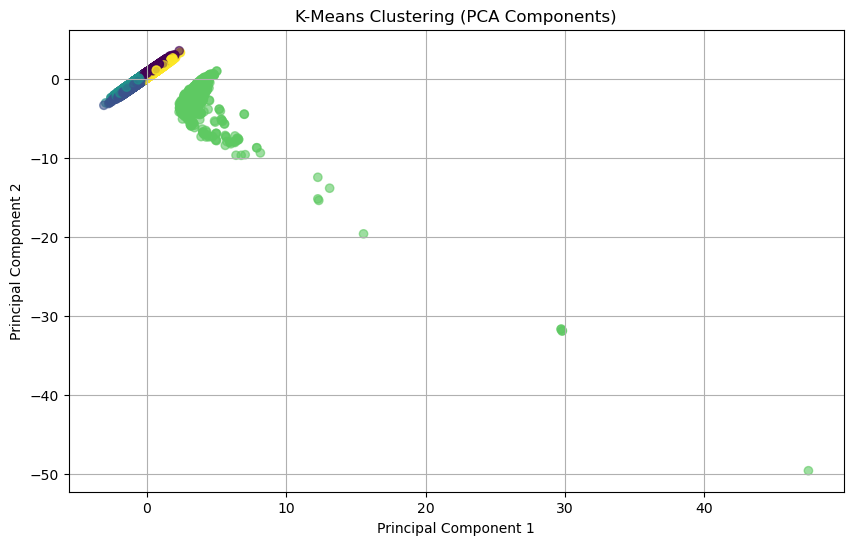

In [7]:
#optimal k clusters = 5

# K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Visualize K-Means Clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
#plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.6)
plt.title('K-Means Clustering (PCA Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()


2. **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**

- DBSCAN is a density-based clustering algorithm that groups together points that are closely packed together. Unlike K-Means, it does not require specifying the number of clusters in advance. Its goal is to identify clusters of arbitrary shape, including clusters with non-spherical shape. It is also useful for detecting outliers and anomalies.
- **How it works:**
  1. **Neighborhood Search:** For each data point, find its neighbors within a specified radius (epsilon).
  2. **Core Points:** Identify core points that have a minimum number of neighbors (minPts) within the epsilon radius.
  3. **Cluster Formation:** Grow clusters by recursively adding neighbors of core points.
  4. **Noise Points:** Points that are not core points or density-reachable from core points are classified as noise.
- **Inputs:** A dataset with numerical features, epsilon (neighborhood radius), minPts (minimum number of points).
- **Outputs:** Cluster assignments for each data point, noise points.
- **Key Hyperparameters:**
  - **Epsilon:** The radius of the neighborhood, defines the distance for neighbors to form dense regions.
  - **MinPts:** The minimum number of points required to form a dense region.
- **Model Selection:**
  - **Epsilon and MinPts:** Selection based on Silhouette Score for every combination of Epsilon and MinPts. Epsilon determines the neighborhood size, while minPts controls the density threshold.
  - Domain Knowledge: Understanding the underlying data and the expected cluster structure can guide the selection of these parameters.

Best silhouette score: 0.5580048999379735
Optimal Parameters: {'eps': 1.4000000000000001, 'min_samples': 7}


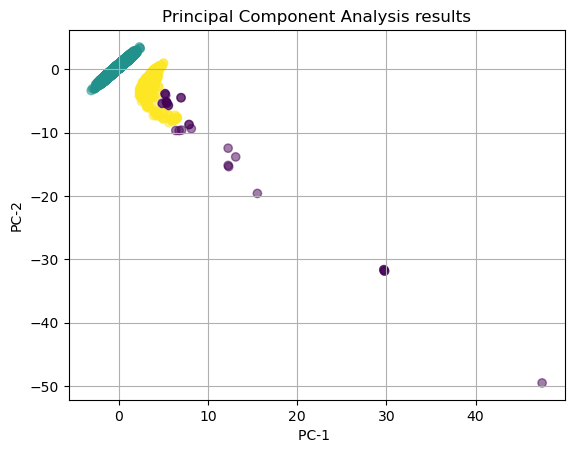

DBSCAN Silhouette Score (Optimal): 0.559


In [8]:
# DBSCAN
# Define ranges for hyperparameters
eps_values = np.arange(0.1, 1.5, 0.1)
min_samples_values = range(2, 10)

# Dictionary to store silhouette scores
best_score = -1
best_params = {}

# Grid search for best Epsilon and MinPts based on silhouette score
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        # Only consider cluster labels with more than one cluster formed
        if len(set(labels)) > 1:
            score = silhouette_score(X_scaled, labels)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

print(f"Best silhouette score: {best_score}")
print(f"Optimal Parameters: {best_params}")

# Apply DBSCAN with optimal parameters
dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
dbscan_labels = dbscan.fit_predict(X_scaled)

# Visualize DBSCAN Clusters
plot_2D(pca_result, dbscan_labels)

# Evaluate Silhouette Score (only for meaningful clusters, excluding noise)
dbscan_clusters = dbscan_labels[dbscan_labels != -1]
if len(set(dbscan_clusters)) > 1:
    silhouette = silhouette_score(X_scaled[dbscan_labels != -1], dbscan_clusters)
    print(f"DBSCAN Silhouette Score (Optimal): {silhouette:.3f}")

3. **Hierarchical Clustering**

- Hierarchical clustering is a clustering algorithm that creates a hierarchy of clusters, starting with each data point as a single cluster and merging them iteratively. It can be either agglomerative (bottom-up) or divisive (top-down). Its purpose is to understand the hierarchical structure of data. It is useful for exploratory data analysis and visualization.

- **How it works:**
  - **Initialization:** Each data point is treated as a single cluster.
  - **Merge:** The two closest clusters are merged based on a distance metric (e.g., single-linkage, complete-linkage, average-linkage, Ward's linkage).
    - **Single-Linkage:** Merge the two clusters with the smallest distance between their closest points.
    - **Complete-Linkage:** Merge the two clusters with the smallest distance between their farthest points.
    - **Average-Linkage:** Merge the two clusters with the smallest average distance between all pairs of points.
    - **Ward's Linkage:** Merge the two clusters that result in the smallest increase in the within-cluster sum of squares.
  - **Iteration:** Steps 2 and 3 are repeated until all data points belong to a single cluster.
- **Inputs:** A dataset with numerical features.
- **Outputs:** A dendrogram representing the hierarchy of clusters.
- **Key Hyperparameters:**
  - **Linkage Criterion:** The method used to calculate the distance between clusters.
  - Dendrogram: A dendrogram visually represents the hierarchy of clusters, allowing for the selection of an appropriate number of clusters by cutting the dendrogram at a desired level. It helps us understand the relationships between data points and identify optimal cluster numbers. Vertical lines represent data points or clusters. Horizontal lines connect clusters that have been merged. The height of the horizontal lines signify the distance or dissimilarity between the merged clusters.

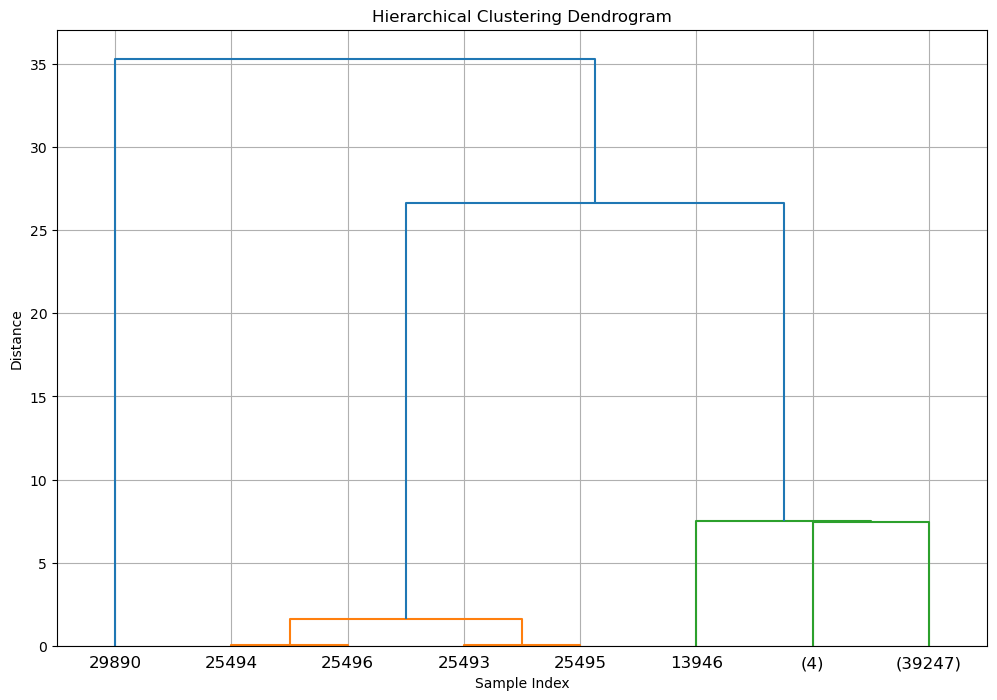

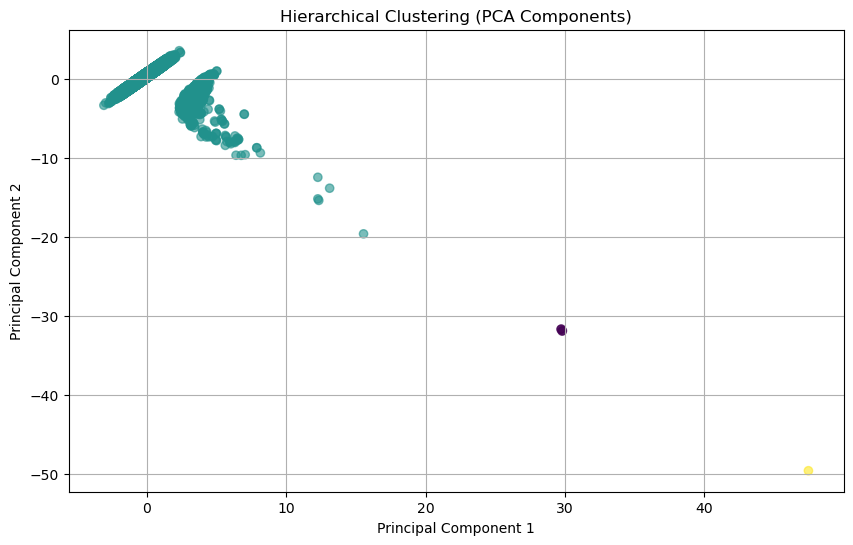

In [9]:
# Hierarchical Clustering
hierarchical = linkage(X_scaled, method='single')

# Dendrogram
plt.figure(figsize=(12, 8))
dendrogram(hierarchical, truncate_mode='level', p=3)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.grid()
plt.show()

# Extract clusters using fcluster
hierarchical_labels = fcluster(hierarchical, t=3, criterion='maxclust')

# Visualize Hierarchical Clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=hierarchical_labels, cmap='viridis', alpha=0.6)
plt.title('Hierarchical Clustering (PCA Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

## **Results Section:**

- **K-Means Clustering:** The Elbow Method and calculation of Silhouette scores pointed to 5 being the optimal number of clusters, yielding a Silhouette Score of 0.315. At k=5, the rate of inertia decrease slows down (as seen in the Elbow Method plot), and it is a local maximum in Silhouette score plot. The PCA visualization of the 5 clusters showed few distinct groups. However, there is a lot of overlap in the top left corner with four of the clusters. 
- **DBSCAN:** After executing a grid search to find the optimal epsilon to be 1.4 and Minimum number of points to be 7, resulting in a Silhouette score of 0.559. This is an improvement on K-means as this density based method presented no identifiable overlap in the clusters and had a higher Silhouette Score. In fact, there are three distinct clusters.
- **Hierchical Clustering:** The dendrogram shows that there three, well-separated, main clusters as signified by colors blue, orange, and green. Within these main clusters, there are further subdivisions into smaller clusters. The cluster on the far left of the diagram is the most different which point to the teal-colored cluster in the PCA representation. 

## **Conclusion:** 
By effectively utilizing the insights from clustering, businesses can make data-driven decisions, optimize processes, and improve overall performance.

**1. Optimal Number of Clusters:** Both DBSCAN and Hierarchical Clustering suggest that there are **three distinct clusters** in the data. This finding implies that the dataset can be divided into three meaningful groups based on their underlying characteristics. Nevertheless, looking at the PCA representations, both methods seem to disagree on the assignment of points to those clusters.

**2. Cluster Characteristics:**
   - **DBSCAN** provides a clearer separation of these clusters, indicating that they are well-defined and distinct.
   - **Hierarchical Clustering** further reveals a hierarchical structure within these clusters, suggesting potential sub-groups or hierarchies.